# 0.0 Initial

## 0.1. Import

In [106]:
#!pip uninstall pandas

In [107]:
#!pip install --upgrade pandas
#!pip install prettytable
!pip install termcolor

In [108]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb

from sklearn    import decomposition   as d
from matplotlib import pyplot          as plt
from sklearn    import model_selection as ms
from keras      import models          as ml
from keras      import layers          as l

from termcolor             import colored
from prettytable           import PrettyTable 
from boruta                import BorutaPy
from keras.callbacks       import EarlyStopping
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression,Lasso
from numpy                 import asarray
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.display       import Image

## 0.2. Helper Functions

In [109]:
def bmi (height, weight):
    bmi = weight/((height/100)**2)
    return bmi

def mean_absolute_error (y,yhat):
    return np.mean(np.abs(y-yhat))

def mean_absolute_percentage_error (y,yhat):
    return np.mean(np.abs(y-yhat)/y)

def mean_squared_error (y,yhat):
    return np.mean(pow((yhat-y),2))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

def perc (x):
    #calculate % people who had CVD
    j = len(x)
    for i in range(len(x)):
        if i < j:
            p = ((x['total'][i])/(x['total'][i+pow(-1,(i+2))]+x['total'][i]))*100
            x['%_cardio_1'][i] = p
        else:
            exit
    return x

## 0.3. Loading Data

In [110]:
df_raw = pd.read_csv('cardio_train.csv', low_memory=False)

In [111]:
df_raw

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


# 1.0. Data Description

In [112]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [113]:
print('Number of columns:', format(df1.shape[1]))
print('Number of rows:', format(df1.shape[0]))

Number of columns: 13
Number of rows: 70000


## 1.2. Data Types

In [114]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.3. Check NA

In [115]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.4. Unit change

In [116]:
#age (int)
df1['age'] = (df1['age']/365).astype(int)

#weight (int)
df1['weight'] = df1['weight'].astype(int)

df1.dtypes

id             int64
age            int32
gender         int64
height         int64
weight         int32
ap_hi          int64
ap_lo          int64
cholesterol    int64
gluc           int64
smoke          int64
alco           int64
active         int64
cardio         int64
dtype: object

## 1.5. Descriptive Statiscal

In [117]:
#central tendency - mean, median
ct1 = pd.DataFrame(df1.apply(np.mean)).T
ct2 = pd.DataFrame(df1.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df1.apply(min)).T
d2 = pd.DataFrame(df1.apply(max)).T
d3 = pd.DataFrame(df1.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df1.apply(np.std)).T
d5 = pd.DataFrame(df1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d1,d2,d3,ct1,ct2,d4,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,99999.0,99999.0,49972.419900,50001.5,28851.096242,-0.001278,-1.198374
1,age,29.0,64.0,35.0,52.840671,53.0,6.766725,-0.305744,-0.818981
2,gender,1.0,2.0,1.0,1.349571,1.0,0.476835,0.630960,-1.601935
3,height,55.0,250.0,195.0,164.359229,165.0,8.210068,-0.642187,7.943653
4,weight,10.0,200.0,190.0,74.204329,72.0,14.395850,1.012030,2.586746
5,ap_hi,-150.0,16020.0,16170.0,128.817286,120.0,154.010319,85.296214,7580.074738
6,ap_lo,-70.0,11000.0,11070.0,96.630414,80.0,188.471184,32.114083,1425.914585
7,cholesterol,1.0,3.0,2.0,1.366871,1.0,0.680245,1.587123,0.993901
8,gluc,1.0,3.0,2.0,1.226457,1.0,0.572266,2.397462,4.294377
9,smoke,0.0,1.0,1.0,0.088129,0.0,0.283482,2.905867,6.444250


# 2.0. Feature Engineering

In [200]:
df2 = df1.copy()

In [119]:
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(['Type','Name', 'Category', 'Code', 'Unity']) 
  
# Add rows 
myTable.add_row(['Identification','Age','Objective Feature', 'age', 'int (days)']) 
myTable.add_row(['Identification','Height','Objective Feature', 'height', 'int (cm)']) 
myTable.add_row(['Identification','Weight','Objective Feature', 'weight', 'float (kg)'])
myTable.add_row(['Identification','Gender','Objective Feature', 'gender', '1 (women) 2 (men)'])
myTable.add_row(['Review of Systems','Systolic blood pressure','Examination Feature', 'ap_hi', 'int'])
myTable.add_row(['Review of Systems','Diastolic blood pressure','Examination Feature', 'ap_lo', 'int'])
myTable.add_row(['Review of Systems','Cholesterol','Examination Feature', 'cholesterol', '1: normal, 2: above, 3: well above'])
myTable.add_row(['Review of Systems','Glucose','Examination Feature', 'gluc', '1: normal, 2: above, 3: well above'])
myTable.add_row(['Habits','Smoking','Subjective Feature', 'smoke', 'binary'])
myTable.add_row(['Habits','Alcohol intake','Subjective Feature', 'alco', 'binary'])
myTable.add_row(['Habits','Physical activity','Subjective Feature', 'active', 'binary'])
myTable.add_row(['Target Variable','Presence/absence of CVD','Target Variable', 'cardio', 'binary'])

print(myTable)

+-------------------+--------------------------+---------------------+-------------+------------------------------------+
|        Type       |           Name           |       Category      |     Code    |               Unity                |
+-------------------+--------------------------+---------------------+-------------+------------------------------------+
|   Identification  |           Age            |  Objective Feature  |     age     |             int (days)             |
|   Identification  |          Height          |  Objective Feature  |    height   |              int (cm)              |
|   Identification  |          Weight          |  Objective Feature  |    weight   |             float (kg)             |
|   Identification  |          Gender          |  Objective Feature  |    gender   |         1 (women) 2 (men)          |
| Review of Systems | Systolic blood pressure  | Examination Feature |    ap_hi    |                int                 |
| Review of Systems | Di

## 2.1 Mind Map Hypothesis

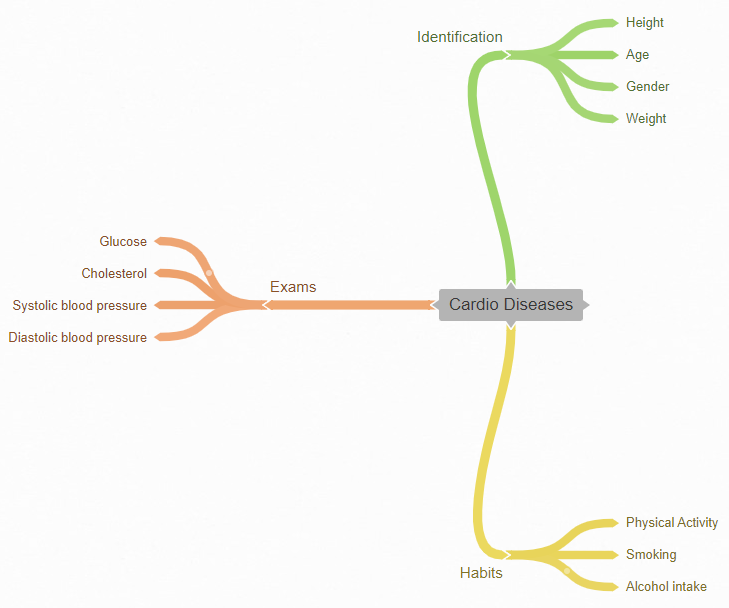

In [120]:
Image('CCD.png')

## 2.2 Hypothesis Creation

### 2.1.1 Identification Hypothesis

**1.** People over 50 are on average 20% more likely to have CVD than under 50

**2.** People shorter than 170 cm (5'7'') have a 5% more chance of CVDs than over 170 cm

**3.** Men are 30% more likely than women to develop a CVD

**4.** People over 100 kg (220 lb) have 40% more chance of having a CVD than 100 kg

**5.** People with a BMI above 30 (obese class I) have 25% more chance of having a CVD than below 30

### 2.1.2 Habits Hypothesis

**1.** People who do not engage in physical activity are 40% more likely to have CVDs than who engage

**2.** People who regularly consume alcohol have a 10% chance of having CVD than those who do not consume

**3.** People who smoke are 20% more likely to have CVD than who do not smoke

### 2.1.3 Exams Hypothesis

**1.** People with well above normal cholesterol have a 50% chance of having CVD than normal

**2.** People with well above normal glucose have a 20% chance of having CVD than normal

**3.** People who have hypertension have 40% chance of having CVD than who have normal blood pressure

## 2.3. Final Hypothesis

**1.** People over 50 are on average 20% more likely to have CVD than under 50

**2.** People shorter than 170 cm (5'7'') have a 5% more chance of CVDs than over 170 cm

**3.** Men are 30% more likely than women to develop a CVD

**4.** People over 100 kg (220 lb) have 40% more chance of having a CVD than 100 kg

**5.** People with a BMI above 30 (obese class I) have 25% more chance of having a CVD than below 30

**6.** People who do not engage in physical activity are 40% more likely to have CVDs than who engage

**7.** People who regularly consume alcohol have a 10% chance of having CVD than those who do not consume

**8.** People who smoke are 20% more likely to have CVD than who do not smoke

**9.** People with well above normal cholesterol have a 50% chance of having CVD than normal

**10.** People with well above normal glucose have a 20% chance of having CVD than normal

**11.** People who have hypertension have 40% chance of having CVD than who have normal blood pressure

## 2.4. Feature Engineering

In [121]:
#BMI
df2['bmi'] = bmi(df2['height'], df2['weight'])

In [201]:
#blood pressure classification
df2['blood_pressure'] = ''

df2['blood_pressure'] = df2.apply(lambda x: '0' if (x['ap_hi'] > 0 and x['ap_hi'] < 120) and (x['ap_lo'] > 0 and x['ap_lo'] < 80) else '' 
                                  '1' if (x['ap_hi'] >= 120 and x['ap_hi'] <= 129) and (x['ap_lo'] < 80) else ''
                                  '2' if (x['ap_hi'] >= 130 and x['ap_hi'] <= 139) or (x['ap_lo'] >= 80 and x['ap_lo'] <= 89) else ''
                                  '3' if (x['ap_hi'] >= 140 and x['ap_hi'] <= 179) or (x['ap_lo'] >= 90 and x['ap_lo'] <= 119) else ''
                                  '4' if x['ap_hi'] >= 180 or x['ap_lo'] >= 120 else '', axis=1)

#remove na
df2['blood_pressure'] = df2['blood_pressure'].dropna()

#transform to (int)
df2['blood_pressure'] = pd.to_numeric(df2['blood_pressure'],errors = 'coerce')
df2['blood_pressure'] = df2['blood_pressure'].astype(int)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [197]:
df2.dtypes

id                  int64
age                 int32
gender              int64
height              int64
weight              int32
ap_hi               int64
ap_lo               int64
cholesterol         int64
gluc                int64
smoke               int64
alco                int64
active              int64
cardio              int64
blood_pressure    float64
dtype: object

# 3.0. Data Filtering

In [123]:
df3 = df2.copy()
df3_full = df2.copy()

In [124]:
#blood pressure
#df3 = df3[~df3['blood_pressure'].isna()]

#height
#df3 = df3[(df3['height'] >= 140) & (df3['height'] <= 200)]

#weight
#df3 = df3[(df3['weight'] >= 50) & (df3['weight'] <= 150)]

#ap_hi
#df3 = df3[(df3['ap_hi'] >= 0) & (df3['ap_hi'] <= 250)]

#ap_lo
#df3 = df3[(df3['ap_lo'] >= 0) & (df3['ap_lo'] <= 250)]

In [125]:
#central tendency - mean, median
ct1 = pd.DataFrame(df3.apply(np.mean)).T
ct2 = pd.DataFrame(df3.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df3.apply(min)).T
d2 = pd.DataFrame(df3.apply(max)).T
d3 = pd.DataFrame(df3.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df3.apply(np.std)).T
d5 = pd.DataFrame(df3.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df3.apply(lambda x: x.kurtosis())).T
d7 = pd.DataFrame(df3.apply(lambda x: len(x))).T

#concatenate
m = pd.concat([d1,d2,d3,ct1,ct2,d4,d5,d6,d7]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis','total']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis,total
0,id,0.000000,99999.000000,99999.000000,49972.419900,50001.500000,28851.096242,-0.001278,-1.198374,70000.0
1,age,29.000000,64.000000,35.000000,52.840671,53.000000,6.766725,-0.305744,-0.818981,70000.0
2,gender,1.000000,2.000000,1.000000,1.349571,1.000000,0.476835,0.630960,-1.601935,70000.0
3,height,55.000000,250.000000,195.000000,164.359229,165.000000,8.210068,-0.642187,7.943653,70000.0
4,weight,10.000000,200.000000,190.000000,74.204329,72.000000,14.395850,1.012030,2.586746,70000.0
5,ap_hi,-150.000000,16020.000000,16170.000000,128.817286,120.000000,154.010319,85.296214,7580.074738,70000.0
6,ap_lo,-70.000000,11000.000000,11070.000000,96.630414,80.000000,188.471184,32.114083,1425.914585,70000.0
7,cholesterol,1.000000,3.000000,2.000000,1.366871,1.000000,0.680245,1.587123,0.993901,70000.0
8,gluc,1.000000,3.000000,2.000000,1.226457,1.000000,0.572266,2.397462,4.294377,70000.0
9,smoke,0.000000,1.000000,1.000000,0.088129,0.000000,0.283482,2.905867,6.444250,70000.0


In [126]:
#calculate summary statistics
data_mean, data_std = m['mean'][3], m['std'][3]
#identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
#identify outliers
df3['outliers'] = ''
df3['outliers'] = df3.apply(lambda x: 'outlier' if (x['height'] < lower or x['height'] > upper) else '', axis=1)

#remove outliers
df3 = df3[(df3['outliers'] != 'outlier')]

In [127]:
#calculate summary statistics
data_mean, data_std = m['mean'][4], m['std'][4]
#identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
#identify outliers
df3['outliers'] = ''
df3['outliers'] = df3.apply(lambda x: 'outlier' if (x['weight'] < lower or x['weight'] > upper) else '', axis=1)

#remove outliers
df3 = df3[(df3['outliers'] != 'outlier')]

In [128]:
#calculate summary statistics
data_mean, data_std = m['mean'][5], m['std'][5]
#identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
#identify outliers
df3['outliers'] = ''
df3['outliers'] = df3.apply(lambda x: 'outlier' if (x['ap_hi'] < lower or x['ap_hi'] > upper) else '', axis=1)

#remove outliers
df3 = df3[(df3['outliers'] != 'outlier')]

In [129]:
#calculate summary statistics
data_mean, data_std = m['mean'][6], m['std'][6]
#identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
#identify outliers
df3['outliers'] = ''
df3['outliers'] = df3.apply(lambda x: 'outlier' if (x['ap_lo'] < lower or x['ap_lo'] > upper) else '', axis=1)

#remove outliers
df3 = df3[(df3['outliers'] != 'outlier')]

In [130]:
#calculate summary statistics
data_mean, data_std = m['mean'][13], m['std'][13]
#identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
#identify outliers
df3['outliers'] = ''
df3['outliers'] = df3.apply(lambda x: 'outlier' if (x['bmi'] < lower or x['bmi'] > upper) else '', axis=1)

#remove outliers
df3 = df3[(df3['outliers'] != 'outlier')]

df3 = df3.drop('outliers', 1)

<ipython-input-130-ee8f72e6fa0e>:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df3 = df3.drop('outliers', 1)


In [131]:
#central tendency - mean, median
ct1 = pd.DataFrame(df3.apply(np.mean)).T
ct2 = pd.DataFrame(df3.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df3.apply(min)).T
d2 = pd.DataFrame(df3.apply(max)).T
d3 = pd.DataFrame(df3.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df3.apply(np.std)).T
d5 = pd.DataFrame(df3.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df3.apply(lambda x: x.kurtosis())).T
d7 = pd.DataFrame(df3.apply(lambda x: len(x))).T

#concatenate
m = pd.concat([d1,d2,d3,ct1,ct2,d4,d5,d6,d7]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis','total']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis,total
0,id,0.000000,99999.00000,99999.000000,49967.314974,50016.500000,28846.218985,-0.000958,-1.197637,67958.0
1,age,29.000000,64.00000,35.000000,52.830660,53.000000,6.768708,-0.303949,-0.820956,67958.0
2,gender,1.000000,2.00000,1.000000,1.347759,1.000000,0.476259,0.639335,-1.591298,67958.0
3,height,140.000000,188.00000,48.000000,164.393640,165.000000,7.678157,0.086521,-0.120945,67958.0
4,weight,32.000000,117.00000,85.000000,73.504621,72.000000,13.127290,0.535674,0.178201,67958.0
5,ap_hi,-150.000000,401.00000,551.000000,126.152903,120.000000,17.826898,-0.089847,9.852724,67958.0
6,ap_lo,-70.000000,602.00000,672.000000,81.277039,80.000000,10.227174,3.977074,190.831898,67958.0
7,cholesterol,1.000000,3.00000,2.000000,1.361679,1.000000,0.676784,1.609394,1.068386,67958.0
8,gluc,1.000000,3.00000,2.000000,1.223314,1.000000,0.569243,2.422682,4.417997,67958.0
9,smoke,0.000000,1.00000,1.000000,0.087333,0.000000,0.282323,2.923431,6.546639,67958.0


# 4.0. Exploratory Data Analysis

In [132]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response variable

In [133]:
#sns.displot(df4['cardio'], kde=True)

### 4.1.2 Numeric variable

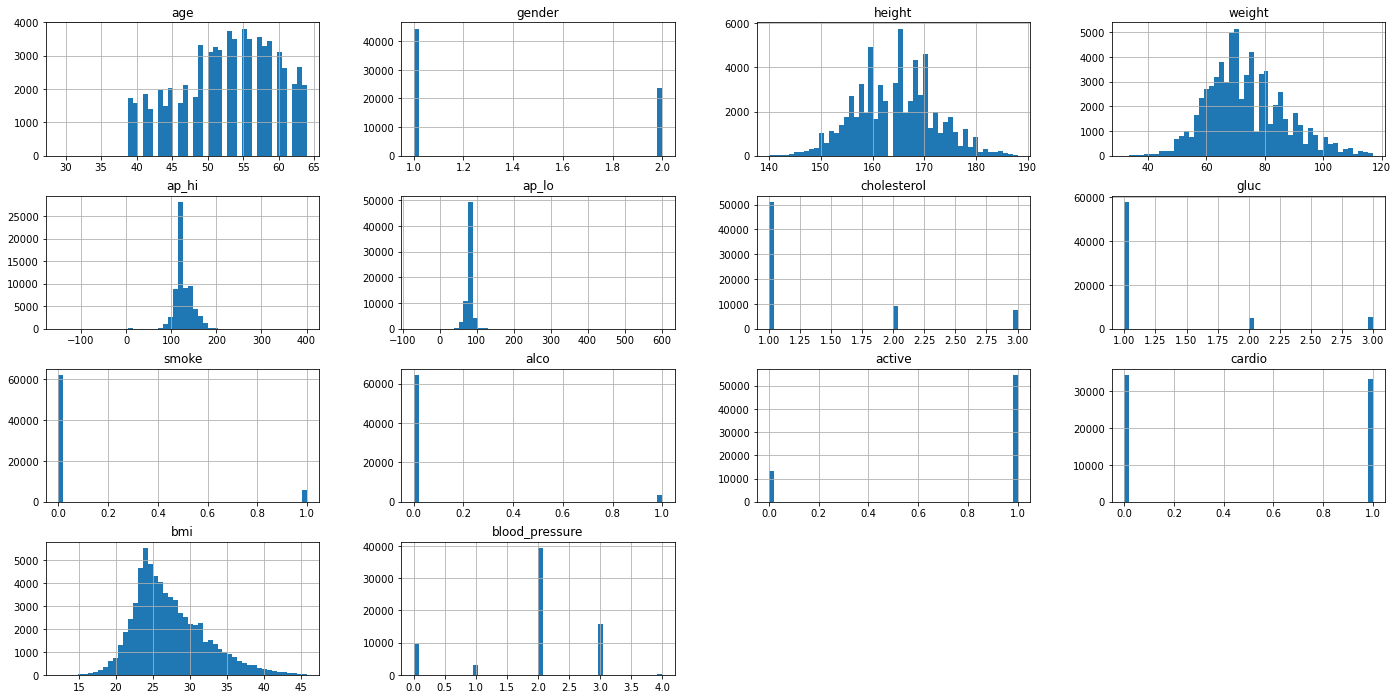

In [134]:
df42 = df4.drop('id', axis=1)
df42.hist(figsize=(24,12), bins=50);

## 4.2. Bivariate Analysis

**1. Analysis between 39 - 64. People over 50 are on average 20% more likely to have CVD than under 50**

**TRUE** On average people over 50 are 56.6% likely to have CVD and 20.9% more likely than under 50. 63 years old has the highest incidence.

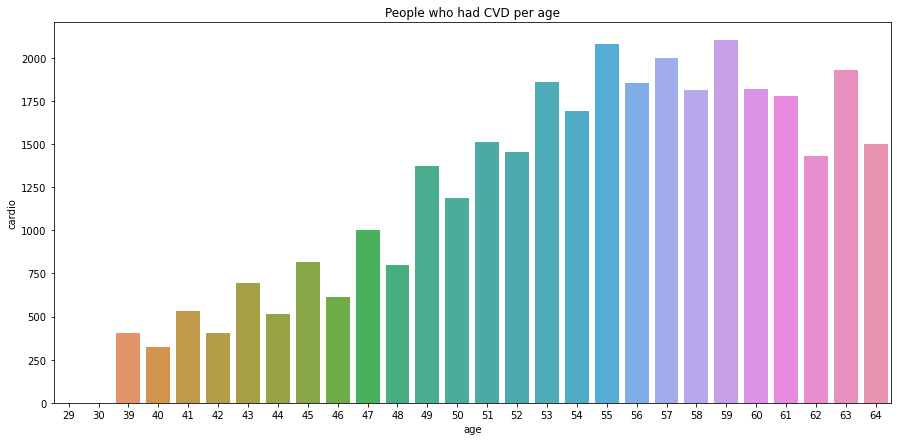

In [135]:
#cvd per age
aux1 = df4[['age', 'cardio']].groupby('age').sum().reset_index().rename(columns={0:'total'})

#histogram
fig_dims = (15, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='age', y='cardio', ax=ax, data=aux1)
plt.title('People who had CVD per age')
plt.show()

In [136]:
#% people with CVD per age
aux1 = df4[(df4['age'] >= 39)]
aux1 = aux1[['age', 'cardio']].groupby(['age','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

<ipython-input-109-6e4d339763c6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


In [137]:
#divide bewtween two groups under and over 50
aux1 = aux1[(aux1['cardio'] >= 1)]
aux_50 = aux1[(aux1['age'] >= 50)]
aux_50 = pd.DataFrame(aux_50.apply(np.mean)).T

aux_49 = aux1[(aux1['age'] < 50)]
aux_49 = pd.DataFrame(aux_49.apply(np.mean)).T

#result of average
m = pd.concat([aux_50, aux_49]).T.reset_index()
m.columns = ['index','over 50','under 50']
m['index'] = {'age': 0, 'cardio': 1, 'total': 2, 'average': 3}
m

,index,over 50,under 50
0,age,57.000000,44.000000
1,cardio,1.000000,1.000000
2,total,1733.066667,680.090909
3,average,56.199688,34.955832


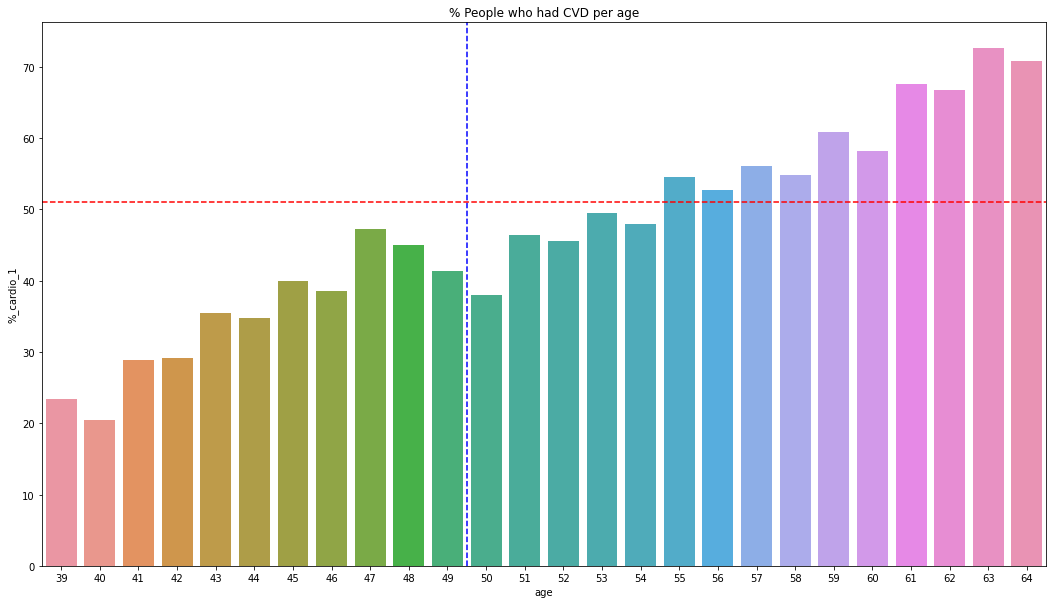

In [138]:
#histogram people who had CVD per age
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='age', y='%_cardio_1', ax=ax, data=aux1)
graph.axvline(10.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per age')
plt.show()

**2. Analysis between 140 - 193 cm. People shorter than 170 cm (5'7'') have a 5% more chance of CVDs than over 170 cm**

**FALSE** On average people shorter than 170 cm have 4.5% more likely to have CVD than over 170.

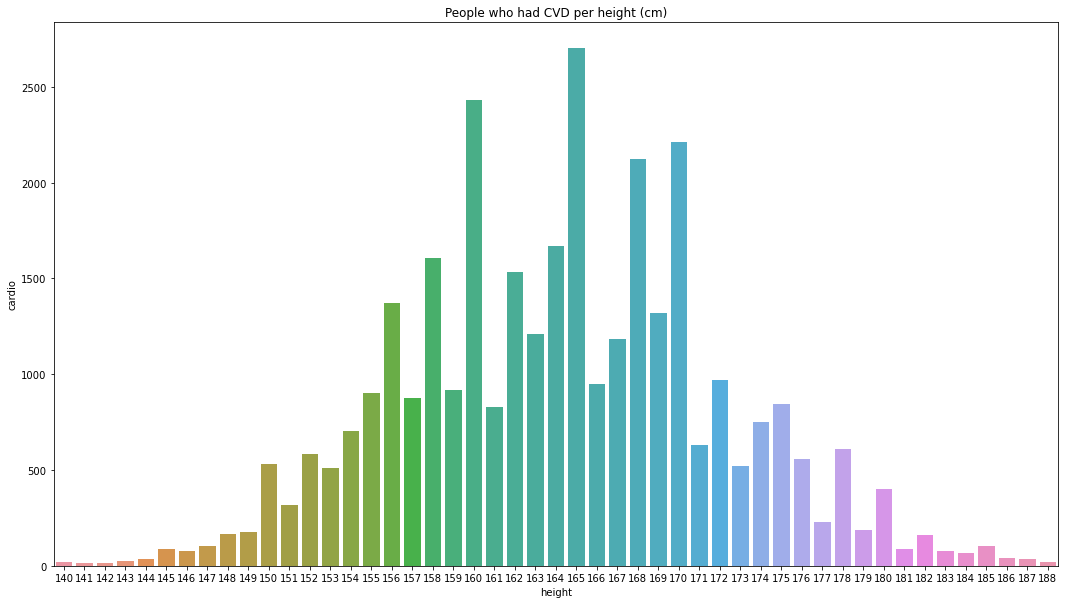

In [139]:
#cvd per height
aux1 = df4[(df4['height'] >= 140) & (df4['height'] <= 193)]
aux1 = aux1[['height', 'cardio']].groupby('height').sum().reset_index()

#histogram
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='height', y='cardio', ax=ax, data=aux1)
plt.title('People who had CVD per height (cm)')
plt.show()

In [140]:
#filter height 140 - 190 and divide between two groups
#aux1 = df4[(df4['cardio'] >= 1) & (df4['height'] >= 140) & (df4['height'] <= 190)]
#aux1 = aux1[['height', 'cardio']].groupby('height').size().reset_index().rename(columns={0:'total_1'})

#aux2 = df4[(df4['cardio'] <= 0) & (df4['height'] >= 140) & (df4['height'] <= 190)]
#aux2 = aux2[['height', 'cardio']].groupby('height').size().reset_index().rename(columns={0:'total_0'})

#fig = plt.figure(figsize=(10,10))

#ax = fig.add_subplot(111)

#width = 0.2

#aux1.plot(x='height', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
#aux2.plot(x='height', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
#plt.show()

In [141]:
#filtering and calculate % people with CVD per height
aux1 = df4[(df4['height'] >= 135) & (df4['height'] <= 193)]
aux1 = aux1[['height', 'cardio']].groupby(['height','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

<ipython-input-109-6e4d339763c6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


In [142]:
#divide bewtween two groups below and over 170
aux1 = aux1[(aux1['cardio'] >= 1)]
aux_170 = aux1[(aux1['height'] >= 170)]
aux_170 = pd.DataFrame(aux_170.apply(np.mean)).T

aux_169 = aux1[(aux1['height'] < 170)]
aux_169 = pd.DataFrame(aux_169.apply(np.mean)).T

#result of average
m = pd.concat([aux_170, aux_169]).T.reset_index()
m.columns = ['index','over 170','below 169']
m['index'] = {'age': 0, 'cardio': 1, 'total': 2, 'average': 3}
m

,index,over 170,below 169
0,age,179.000000,154.500000
1,cardio,1.000000,1.000000
2,total,446.842105,832.900000
3,average,48.707424,52.048776


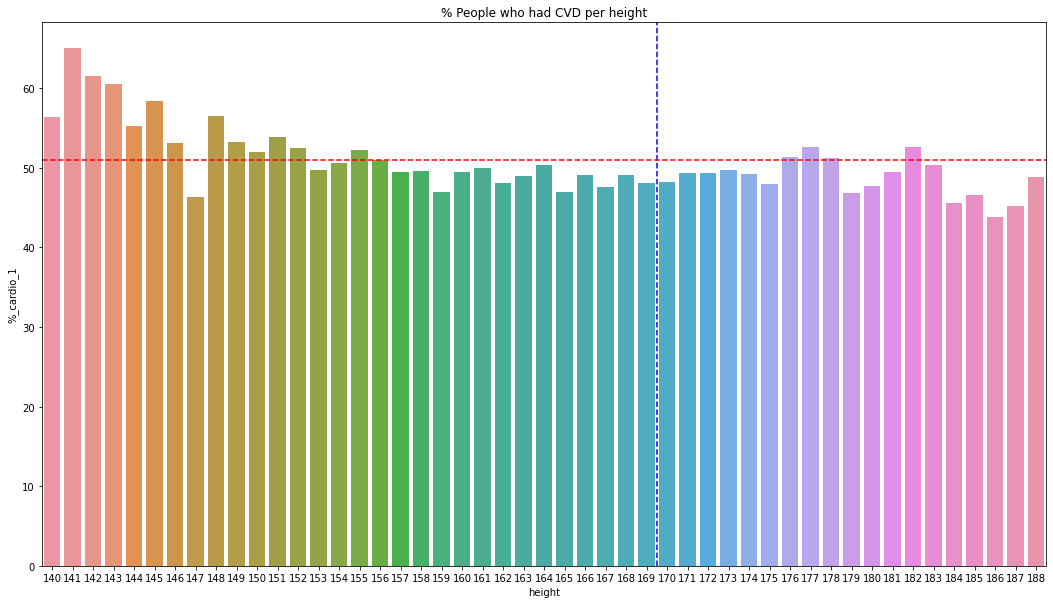

In [143]:
#histogram people who had CVD per height
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='height', y='%_cardio_1', ax=ax, data=aux1)
graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per height')
plt.show()

**3. Men are 30% more likely than women to develop a CVD**

**FALSE** Although men had more CVD than women, the gap are lesser than 30%. Men had 50,1% of cases of CVD, while women had 49,6%

In [144]:
#transform to categorical
df42 = df4.copy()
df42['gender'] = df42['gender'].apply({1:'women', 2:'men'}.get)

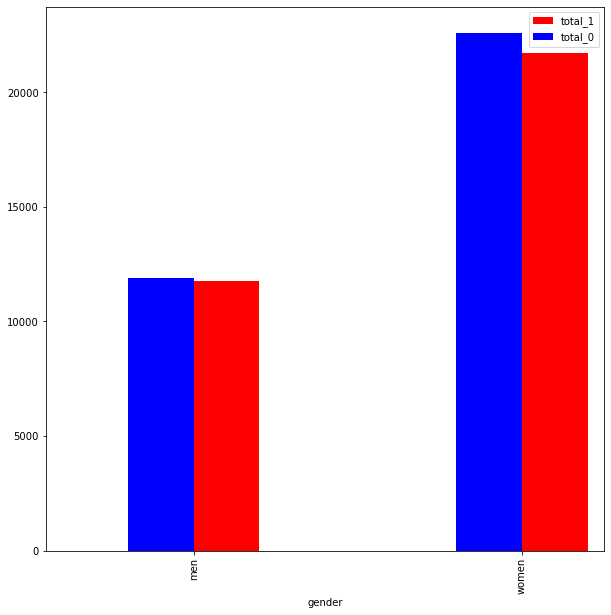

In [145]:
#cvd per height
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['gender', 'cardio']].groupby('gender').size().reset_index().rename(columns={0:'total_1'})

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['gender', 'cardio']].groupby('gender').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='gender', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='gender', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [146]:
#calculate % people with CVD per gender
aux1 = df42[['gender', 'cardio']].groupby(['gender','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1

<ipython-input-109-6e4d339763c6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,gender,cardio,total,%_cardio_1
1,men,1,11748,49.710151
3,women,1,21729,49.021997


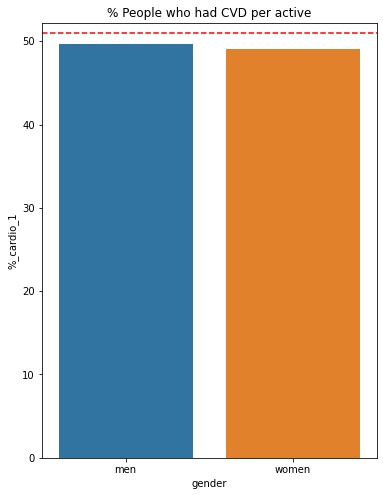

In [147]:
#histogram people who had CVD per gender (average)
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='gender', y='%_cardio_1', ax=ax, data=aux1)
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per active')
plt.show()

**4. Analysis between 50 - 130. People over 100 kg (220 lb) have 40% more chance of having a CVD than 100 kg**

**FALSE** On average people with over 100 kg have 19.9% more chance of having a CVD than below 100 kg

<AxesSubplot:xlabel='weight', ylabel='cardio'>

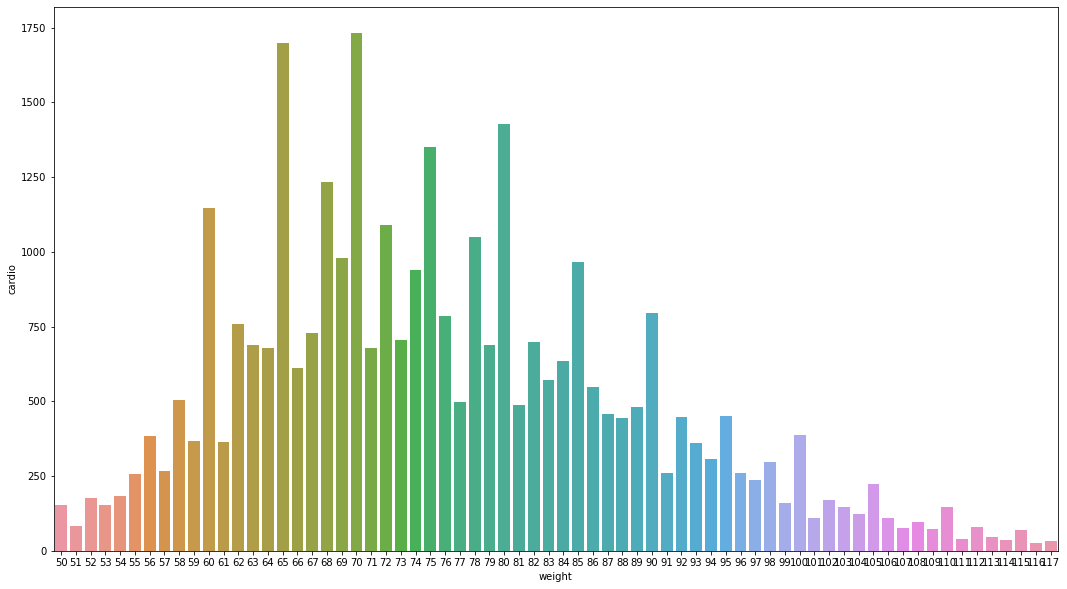

In [148]:
#cvd per weight
aux1 = df4[(df4['weight'] >= 50) & (df4['weight'] <= 130)]
aux1 = aux1[['weight', 'cardio']].groupby('weight').sum().reset_index()

#histogram
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='weight', y='cardio', ax=ax, data=aux1)

In [149]:
#filter weight 33 - 100 and divide between two groups
#aux1 = df4[(df4['weight'] >= 33) & (df4['weight'] <= 100) & (df4['cardio'] >= 1)]
#aux1 = aux1[['weight', 'cardio']].groupby('weight').size().reset_index().rename(columns={0:'total_1'})

#aux2 = df4[(df4['weight'] >= 33) & (df4['weight'] <= 100) & (df4['cardio'] <= 0)]
#aux2 = aux2[['weight', 'cardio']].groupby('weight').size().reset_index().rename(columns={0:'total_0'})

In [150]:
#filtering and calculate % people with CVD per weight
aux1 = df4[(df4['weight'] >= 50) & (df4['weight'] <= 130)]
aux1 = aux1[['weight', 'cardio']].groupby(['weight','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

<ipython-input-109-6e4d339763c6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


In [151]:
#divide bewtween two groups below and over 100 kg
aux1 = aux1[(aux1['cardio'] >=1)]
aux_100 = aux1[(aux1['weight'] >= 100)]
aux_100 = pd.DataFrame(aux_100.apply(np.mean)).T

aux_99 = aux1[(aux1['weight'] < 100)]
aux_99 = pd.DataFrame(aux_99.apply(np.mean)).T

#result of average
m = pd.concat([aux_100, aux_99]).T.reset_index()
m.columns = ['index','over 100','below 100']
m['index'] = {'age': 0, 'cardio': 1, 'total': 2, 'average': 3}
m

,index,over 100,below 100
0,age,108.500000,74.500000
1,cardio,1.000000,1.000000
2,total,110.611111,624.520000
3,average,68.748509,49.890194


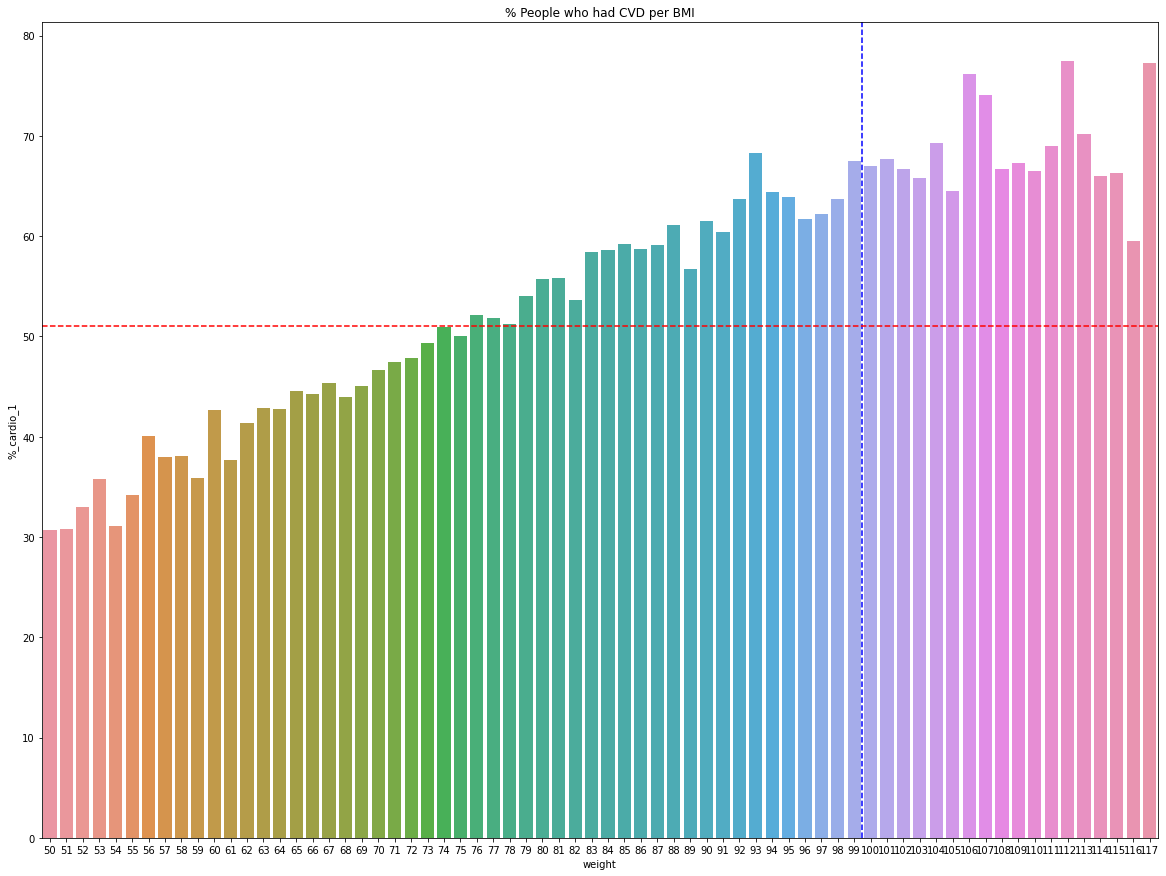

In [152]:
#histogram people who had CVD per height
fig_dims = (20,15)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='weight', y='%_cardio_1', ax=ax, data=aux1)
graph.axvline(49.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per BMI')
plt.show()

**5. People with a BMI above 30 (obese class I) have 25% more chance of having a CVD than below 30**

**TRUE** People with a BMI above than 30 have 26.3% chance of having CVD than BMI below 30

In [153]:
#convert type bmi (int)
df4['bmi'] = df4['bmi'].astype(int)

<AxesSubplot:xlabel='bmi', ylabel='cardio'>

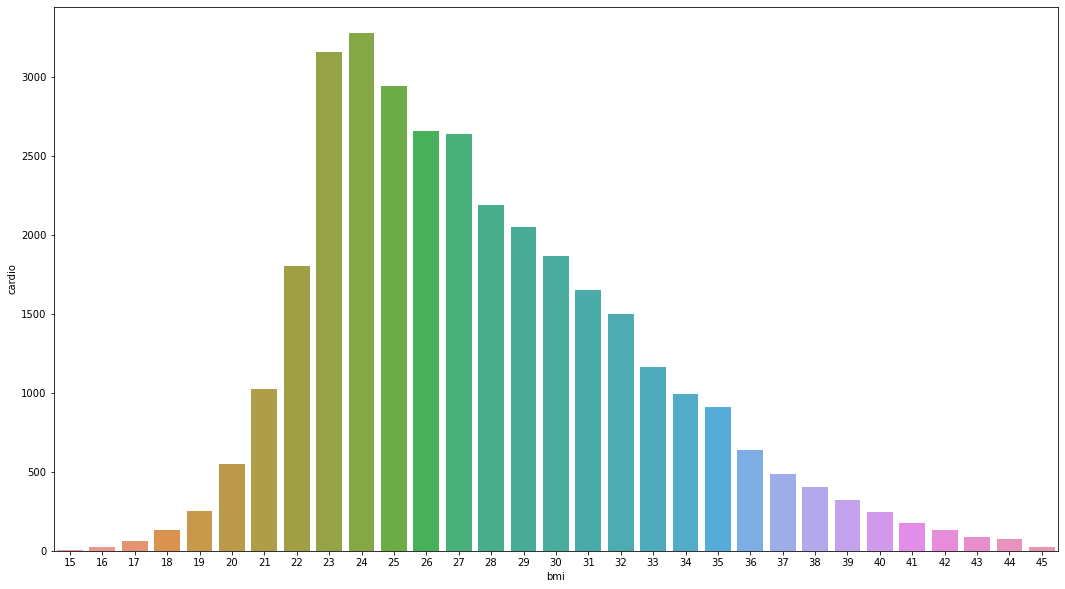

In [154]:
#cvd per weight
aux1 = df4[(df4['bmi'] >= 15) & (df4['bmi'] <= 50)]
aux1 = aux1[['bmi', 'cardio']].groupby('bmi').sum().reset_index()

#histogram
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='bmi', y='cardio', ax=ax, data=aux1)

In [155]:
#calculate % people with CVD per bmi
aux1 = df4[(df4['bmi'] >= 15) & (df4['bmi'] <= 50)]
aux1 = aux1[['bmi', 'cardio']].groupby(['bmi','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

<ipython-input-109-6e4d339763c6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


In [156]:
#divide between two groups below and over 30
aux1 = aux1[(aux1['cardio'] >=1)]
aux_30 = aux1[(aux1['bmi'] >= 30)]
aux_30 = pd.DataFrame(aux_30.apply(np.mean)).T

aux_29 = aux1[(aux1['bmi'] < 30)]
aux_29 = pd.DataFrame(aux_29.apply(np.mean)).T

#result of average
m = pd.concat([aux_30, aux_29]).T.reset_index()
m.columns = ['index','over 30','above 30']
m['index'] = {'age': 0, 'cardio': 1, 'total': 2, 'average': 3}
m

,index,over 30,above 30
0,age,37.500000,22.000000
1,cardio,1.000000,1.000000
2,total,667.687500,1519.133333
3,average,65.873918,38.426496


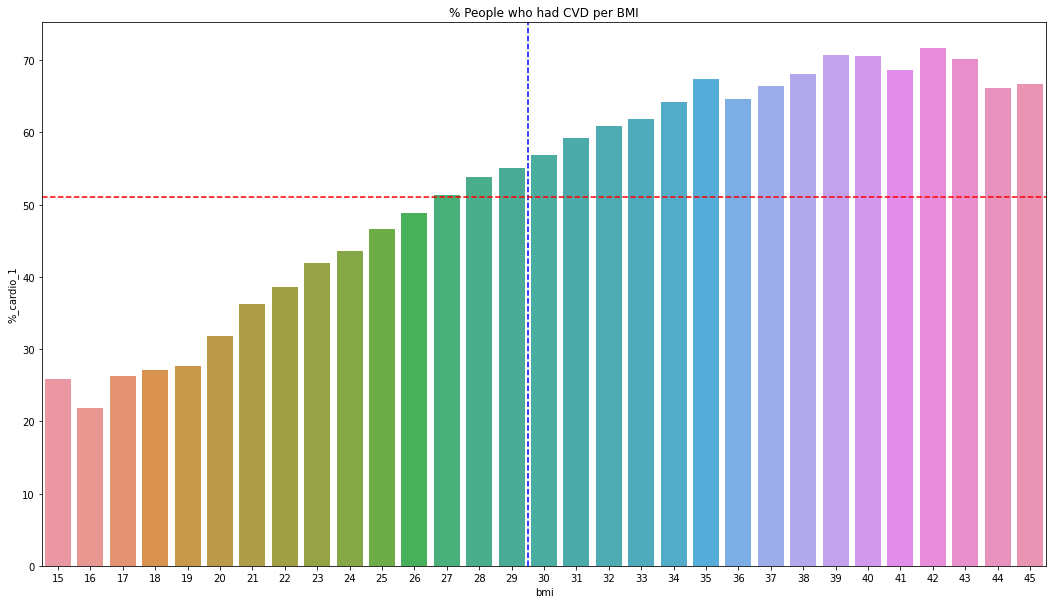

In [157]:
#histogram people who had CVD per BMI
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='bmi', y='%_cardio_1', ax=ax, data=aux1)
graph.axvline(14.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per BMI')
plt.show()

**6. People who do not engage in physical activity are 40% more likely to have CVDs than who engage**

**FALSE** People who engage in physical activity more have 4.6% chance of having CVD

In [158]:
#transform to categorical
df42 = df4.copy()
df42['active'] = df42['active'].apply({0:'no', 1:'yes'}.get)

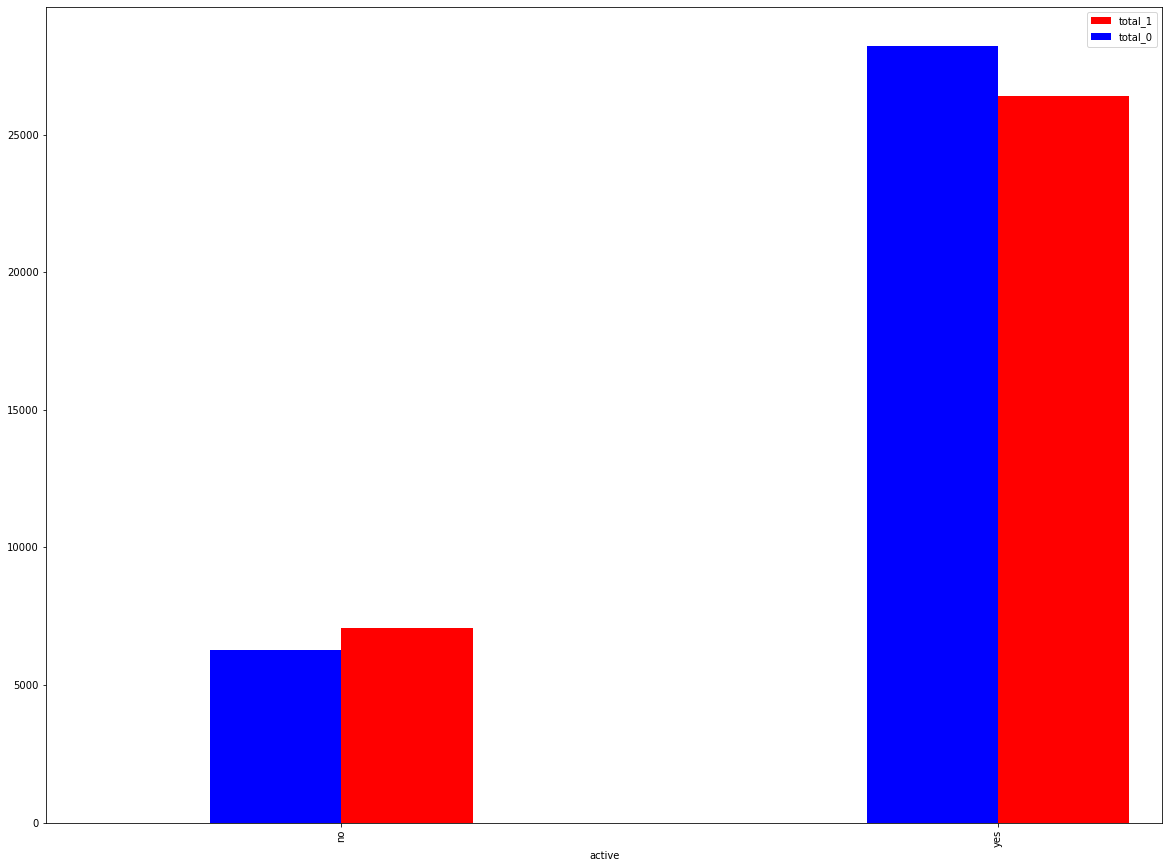

In [159]:
#cvd per physical activity
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['active', 'cardio']].groupby('active').size().reset_index().rename(columns={0:'total_1'})

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['active', 'cardio']].groupby('active').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='active', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='active', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [160]:
#calculate % people with CVD per activity
aux1 = df4[['active', 'cardio']].groupby(['active','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1['active'] = aux1['active'].apply({0:'no', 1:'yes'}.get)
aux1

<ipython-input-109-6e4d339763c6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,active,cardio,total,%_cardio_1
1,no,1,7074,53.048369
3,yes,1,26403,48.336781


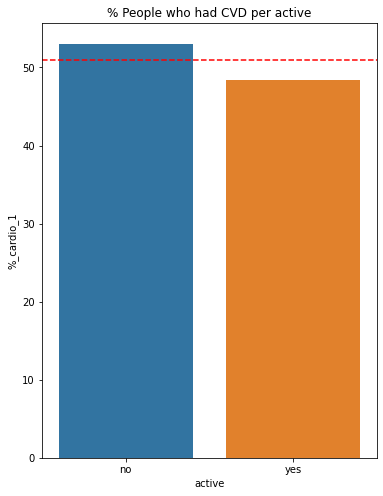

In [161]:
#histogram people who had CVD per activity
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='active', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per active')
plt.show()

**7. People who regularly consume alcohol have a 10% chance of having CVD than those who do not consume**

**FALSE** People who regularly consume alcohol have 1.9% less chance of having CVD than who don't consume

In [162]:
#transform to categorical
df42 = df4.copy()
df42['alco'] = df42['alco'].apply({0:'no', 1:'yes'}.get)

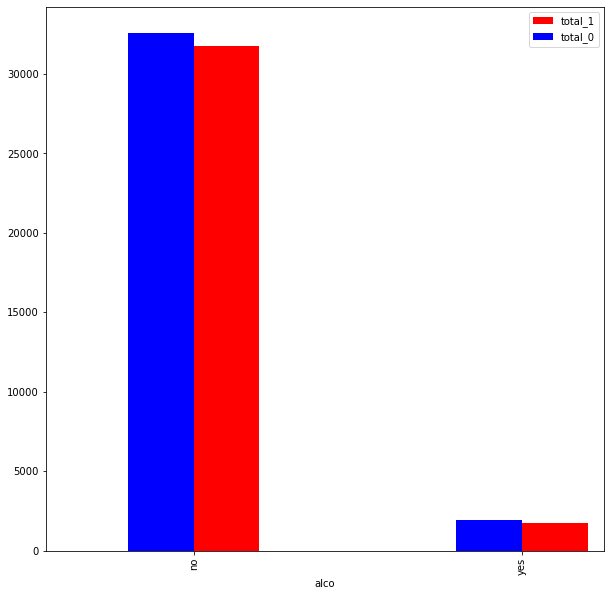

In [163]:
#cvd per people who consume alcohol
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['alco', 'cardio']].groupby('alco').size().reset_index().rename(columns={0:'total_1'})

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['alco', 'cardio']].groupby('alco').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='alco', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='alco', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [164]:
#calculate % people with CVD per people who consume alcohol
aux1 = df42[['alco', 'cardio']].groupby(['alco','cardio']).size().reset_index().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1

<ipython-input-109-6e4d339763c6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,index,alco,cardio,total,%_cardio_1
1,1,no,1,31760,49.360459
3,3,yes,1,1717,47.496542


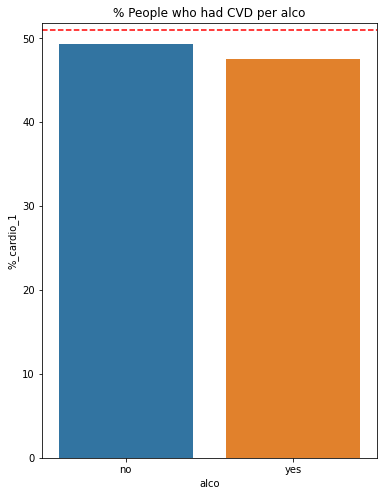

In [165]:
#histogram people who had CVD per per people who consume alcohol
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='alco', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per alco')
plt.show()

**8. People who smoke are 20% more likely to have CVD than who do not smoke**

**FALSE** People who smoke have 3% less chance of having CVD than who doesn't

In [166]:
#transform to categorical
df42 = df4.copy()
df42['smoke'] = df42['smoke'].apply({0:'no', 1:'yes'}.get)

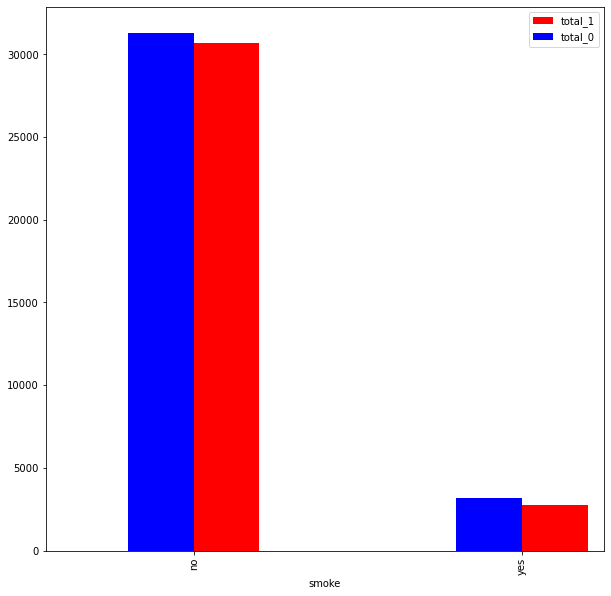

In [167]:
#cvd per people who smoke
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['smoke', 'cardio']].groupby('smoke').size().reset_index().rename(columns={0:'total_1'})

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['smoke', 'cardio']].groupby('smoke').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='smoke', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='smoke', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [168]:
#calculate % people with CVD per people who smoke
aux1 = df42[['smoke', 'cardio']].groupby(['smoke','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1

<ipython-input-109-6e4d339763c6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,smoke,cardio,total,%_cardio_1
1,no,1,30717,49.525176
3,yes,1,2760,46.503791


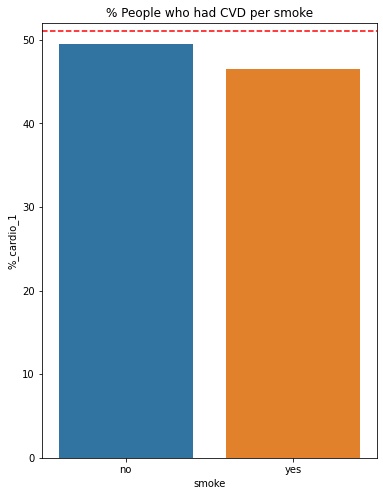

In [169]:
#histogram people who had CVD per people who smoke
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='smoke', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per smoke')
plt.show()

**9. People with well above normal cholesterol have a 50% chance of having CVD than normal**

**FALSE** People with well above normal cholesterol have 33% likely than people with normal

In [170]:
#transform to categorical
df42 = df4.copy()
df42['cholesterol'] = df42['cholesterol'].apply({1:'normal', 2:'above normal', 3:'well above normal'}.get)

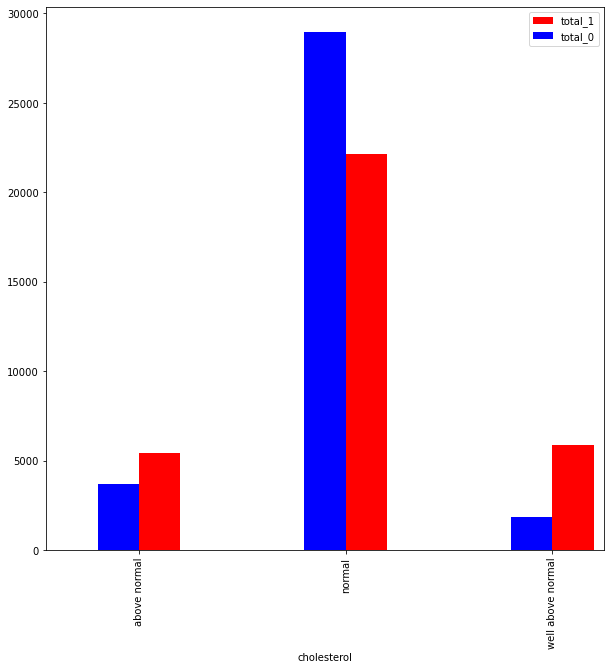

In [171]:
#cvd per people who have above normal cholesterol
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['cholesterol', 'cardio']].groupby('cholesterol').size().reset_index().rename(columns={0:'total_1'})

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['cholesterol', 'cardio']].groupby('cholesterol').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='cholesterol', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='cholesterol', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [172]:
#calculate % people with CVD per people who have above normal cholesterol
aux1 = df42[['cholesterol', 'cardio']].groupby(['cholesterol','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1

<ipython-input-109-6e4d339763c6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,cholesterol,cardio,total,%_cardio_1
1,above normal,1,5435,59.45739
3,normal,1,22162,43.371561
5,well above normal,1,5880,76.17567


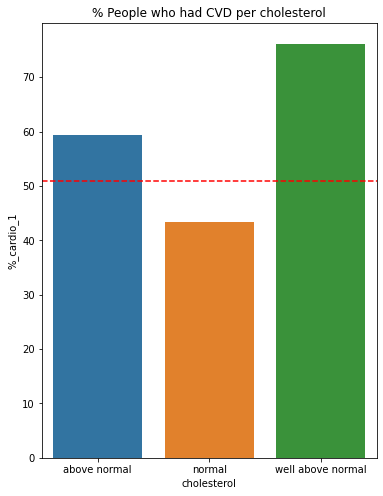

In [173]:
#histogram people who had CVD per people who have above normal cholesterol
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='cholesterol', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per cholesterol')
plt.show()

**10. People with well above normal glucose have a 20% chance of having CVD than normal**

**FALSE** People with well above normal glucose have 14.1% more likely than people with normal glucose

In [174]:
#transform to categorical
df42 = df4.copy()
df42['gluc'] = df42['gluc'].apply({1:'normal', 2:'above normal', 3:'well above normal'}.get)

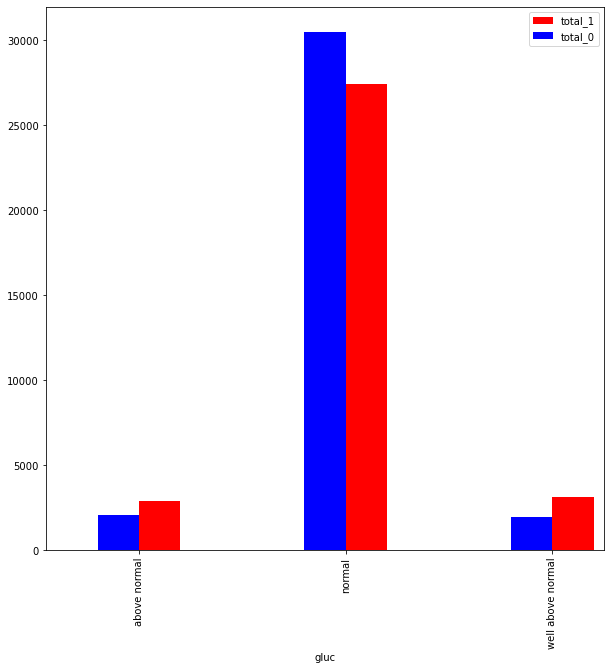

In [175]:
#cvd per people who have above normal glucose
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['gluc', 'cardio']].groupby('gluc').size().reset_index().rename(columns={0:'total_1'})

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['gluc', 'cardio']].groupby('gluc').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='gluc', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='gluc', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [176]:
#calculate % people with CVD per people who have above normal glucose
aux1 = df42[['gluc', 'cardio']].groupby(['gluc','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1

<ipython-input-109-6e4d339763c6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,gluc,cardio,total,%_cardio_1
1,above normal,1,2891,58.498584
3,normal,1,27433,47.380784
5,well above normal,1,3153,61.618136


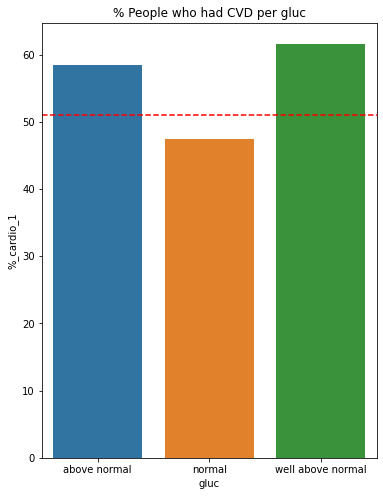

In [177]:
#histogram people who had CVD per people who have above normal glucose
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='gluc', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per gluc')
plt.show()

**11. People who have hypertension have 40% chance of having CVD than who have normal blood pressure**

**TRUE** People with hypertension 3 have 54.2% more chance of having a CVD than people with normal blood pressure

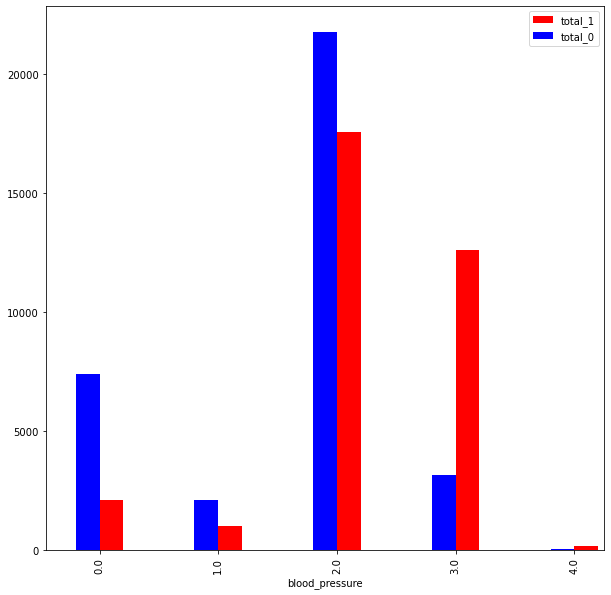

In [178]:
#cvd per people who have hypertension
aux1 = df4[(df4['cardio'] >= 1)]
aux1 = aux1[['blood_pressure', 'cardio']].groupby('blood_pressure').size().reset_index().rename(columns={0:'total_1'})


aux2 = df4[(df4['cardio'] <= 0)]
aux2 = aux2[['blood_pressure', 'cardio']].groupby('blood_pressure').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='blood_pressure', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='blood_pressure', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [179]:
#calculate % people with CVD per people who have hypertension
aux1 = df4[['blood_pressure', 'cardio']].groupby(['blood_pressure','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1

<ipython-input-109-6e4d339763c6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,blood_pressure,cardio,total,%_cardio_1
1,0.0,1,2117,22.216392
3,1.0,1,996,32.285251
5,2.0,1,17594,44.685444
7,3.0,1,12598,80.043205
9,4.0,1,171,76.0


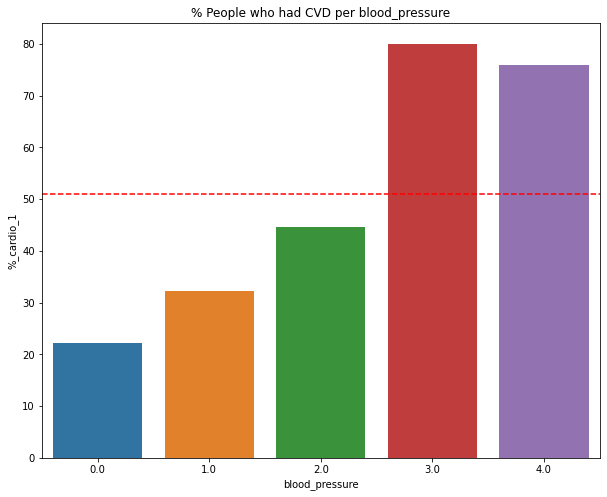

In [180]:
#histogram people who had CVD per people who have hypertension
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='blood_pressure', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per blood_pressure')
plt.show()

## 4.3. Multivariate Analysis

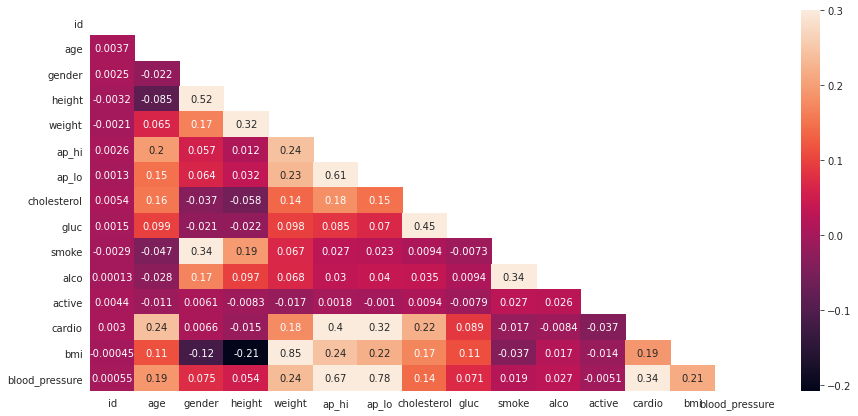

In [181]:
correlations = df4.corr(method='pearson')
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
#fig_dims = (15, 7)
#fig, ax = plt.subplots(figsize=fig_dims)
#sns.heatmap(correlations,ax=ax, annot=True);

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 7))
    ax = sns.heatmap(correlations, mask=mask, vmax=.3, annot=True)

# 5.0. Data Preparation

In [182]:
df5 = df4.copy()

## 5.1. Normalization

In [183]:
# define min max scaler
scaler_mm = MinMaxScaler()
scaler_std = StandardScaler()

# transform weight - STD
df5['weight'] = scaler_mm.fit_transform(df5[['weight']].values)

# transform height - STD
df5['height'] = scaler_mm.fit_transform(df5[['height']].values)

# transform age - MM
df5['age'] = scaler_mm.fit_transform(df5[['age']].values)

# transform bmi - MM
df5['bmi'] = scaler_mm.fit_transform(df5[['bmi']].values)

# transform ap_hi - MM
df5['ap_hi'] = scaler_mm.fit_transform(df5[['ap_hi']].values)

# transform ap_lo - MM
df5['ap_lo'] = scaler_mm.fit_transform(df5[['ap_lo']].values)

df5

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,blood_pressure
0,0,0.600000,2,0.583333,0.352941,0.471869,0.223214,1,1,0,0,1,0,0.272727,2.0
1,1,0.742857,1,0.333333,0.623529,0.526316,0.238095,3,1,0,0,1,1,0.666667,3.0
2,2,0.628571,1,0.520833,0.376471,0.508167,0.208333,3,1,0,0,0,1,0.333333,2.0
3,3,0.542857,2,0.604167,0.588235,0.544465,0.252976,1,1,0,0,1,1,0.484848,3.0
4,4,0.514286,1,0.333333,0.282353,0.453721,0.193452,1,1,0,0,0,0,0.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,0.800000,1,0.520833,0.564706,0.544465,0.223214,1,1,0,0,1,1,0.515152,2.0
69995,99993,0.657143,2,0.583333,0.517647,0.490018,0.223214,1,1,1,0,1,0,0.424242,2.0
69997,99996,0.657143,2,0.895833,0.858824,0.598911,0.238095,3,1,0,1,0,1,0.575758,3.0
69998,99998,0.914286,1,0.479167,0.470588,0.517241,0.223214,1,2,0,0,0,1,0.454545,2.0


# 6.0. Feature Selection

In [202]:
df6 = df5.copy()

In [204]:
#drop id, ap_hi, ap_lo
df6 = df6.drop(['id','blood_pressure'], axis=1)


X = df6.drop(['cardio'], axis=1)
y = df6['cardio'].copy()

In [205]:
#split dataset into train and test
x, x_test, y, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)
x_train, x_val, y_train, y_val = ms.train_test_split( x, y, test_size=0.2 )

## 6.1. Boruta as feature selector

In [206]:
#training and test dataset for Boruta
#x_train_n = x_train.values
#y_train_n = y_train.values.ravel()

#define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
#boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

## 6.1.1 Best feature from Boruta

In [188]:
#cols_selected = boruta.support_.tolist()

#best feature
#x_train_fs = x_train
#cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()
#cols_selected_boruta

#not selected from Boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
#cols_not_selected_boruta

# 7.0. Machine Learning Modeling

## 7.1. Linear Regression Model

In [207]:
#model
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,0.685494,inf,0.785659


## 6.2. Linear Regression Regularized Model - Lasso

In [ ]:
#model
lrr = Lasso(alpha = 0.2).fit(x_train,y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression Regularized', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

## 6.3. Random Forest Regressor

In [ ]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train,y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

## 6.4. XGBoost

In [ ]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytee=0.9).fit(x_train,y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

## 6.5. Neural Network - MLP

In [ ]:
x_val.shape

In [ ]:
#model definition
model = ml.Sequential()
model.add(l.Dense(11, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(1, activation='softmax'))

#model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#train model
es = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10000, callbacks=[es], verbose=1)

In [ ]:
##model evaluate
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, val_acc = model.evaluate(x_val, y_val, verbose=0)

print('Train ACC:{} - Val ACC:{}'.format(train_acc, val_acc ))

In [ ]:
#define the number of eigenvectors (autovetor) + eigenvalues (autovalores)
pca = d.PCA().fit(x_train)
k = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.99)

#change data to new space
pca = d.PCA(k).fit(x_train)

x_train = pca.transform(x_train)
x_val = pca.transform(x_val)

In [ ]:
#ohe = pp.OneHotEncoder()
#y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
#y_val = ohe.transform(y_val.values.reshape(-1, 1)).toarray()

In [ ]:
#model definition
model = ml.Sequential()
model.add(l.Dense(11, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(1, activation='softmax'))

#model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#train model
es = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[es], verbose=0)

In [ ]:
##model evaluate
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, val_acc = model.evaluate(x_val, y_val, verbose=0)

print('Train ACC:{} - Val ACC:{}'.format(train_acc, val_acc ))